About this notebook
-------------
- This notebook is related to classifying different types of mask classification using Pytorch deep learning model.

- This work is used CNN  a feature extractor

- A pretrained ResNet is used for extracting features from images

- At the end of the implementation, do a performance Analysis.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import random
import torch
import cv2
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as Acivation
from sklearn.model_selection import train_test_split
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os, cv2
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
#access to google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import zipfile
# zip_path = '/content/drive/MyDrive/Mask CLF/Face_Mask_Dataset.zip'   # the path of dataset as zip
# zip_ref = zipfile.ZipFile(zip_path, 'r')
# file = zip_ref.extractall("./mask-data")
# zip_ref.close()

# print("o")


In [5]:
# num of classes
CATEGORIES = ['ClothMask', 'N95Mask', 'SurgicalMask', 'WithoutMask']

# train root path, which unzip from previous cell
DATASET = '/content/mask-data/Face_Mask_Dataset/Train/'

In [6]:
# accessing the images and thier corresponding labels
train_data=[]

for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in os.listdir(path):
            
            try:
                img=cv2.imread(os.path.join(path,img_file),1)
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img=cv2.resize(img,(224,224))
                train_data.append([img,label])

            except:
                print("Exception: ",img_file)


print(len(train_data))

Exception:  231.gif
Exception:  313.gif
Exception:  231 (Small).gif
Exception:  313 (Small).gif
Exception:  desktop.ini
2661


In [7]:
# make shuffle amoung the data for mixing up
random.shuffle(train_data)
random.shuffle(train_data)
random.shuffle(train_data)
random.shuffle(train_data)

random.shuffle(train_data)
random.shuffle(train_data)
random.shuffle(train_data)
random.shuffle(train_data)

2       SurgicalMask


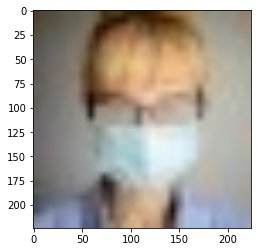

2       SurgicalMask


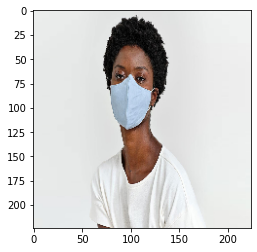

1       N95Mask


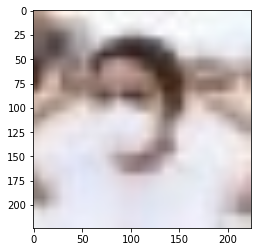

3       WithoutMask


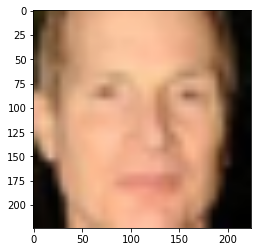

0       ClothMask


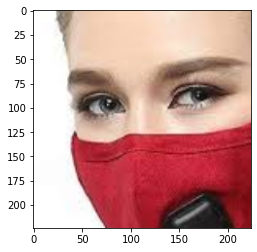

1       N95Mask


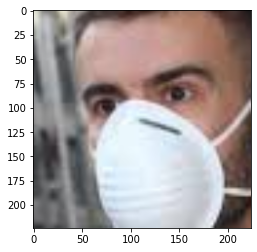

2       SurgicalMask


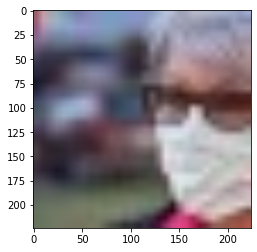

0       ClothMask


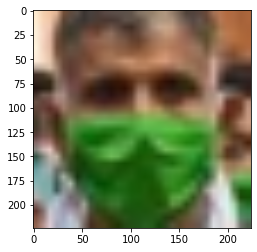

3       WithoutMask


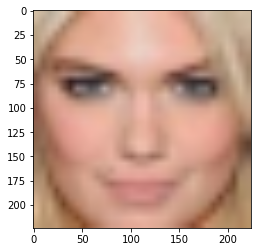

0       ClothMask


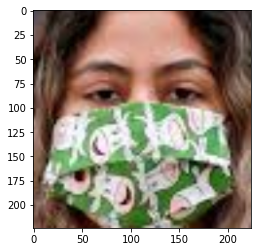

In [8]:
for i in range(10):
    indx = i
    plt.imshow(train_data[indx][0])
    print(train_data[indx][1], "     ", CATEGORIES[train_data[indx][1]])
    plt.show()

In [9]:
X, y = [], []
for features,label in train_data:
    X.append(features)
    y.append(label)

In [10]:
X_arr = np.array(X).reshape(-1, 224,224,3)
y_arr = np.array(y)
X_arr.shape, y_arr.shape

((2661, 224, 224, 3), (2661,))

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_arr, y_arr, test_size=0.2, shuffle=True, random_state=9990)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape 

((2128, 224, 224, 3), (533, 224, 224, 3), (2128,), (533,))

In [12]:
# this class for creating dataloader of mask dataset
class MASK_DATASET(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        x_batch = self.x[index]
        y_batch = self.y[index]

        if self.transform is not None:
            x_batch = self.transform(x_batch)
        
        y_batch = torch.from_numpy(np.array(y_batch))

        return x_batch, y_batch

In [13]:
transform1 = transforms.Compose([
    #transforms.Resize(224, 224),
    transforms.ToTensor(),
    transforms.Normalize( (0.5, ), (0.5, ) )
])


train_dataset = MASK_DATASET(X_train, y_train, transform=transform1)
valid_dataset = MASK_DATASET(X_valid, y_valid, transform=transform1)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {
    "train" : train_loader,
    "val" : valid_loader
}

dataset_sizes = {
    "train" : len(train_dataset),
    "val" : len(valid_dataset)
}


dataiter = iter(train_loader)
images, label = dataiter.next()

print(images.shape, label.shape)

torch.Size([4, 3, 224, 224]) torch.Size([4])


In [14]:
class_names = CATEGORIES

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_history = []
    acc_history =  []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


            loss_history.append(epoch_loss)
            acc_history.append(epoch_acc)
            

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [24]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



In [28]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                print()

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 4.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [18]:
model_ft, model_acc, model_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7917 Acc: 0.6936
val Loss: 0.3931 Acc: 0.8499

Epoch 1/24
----------
train Loss: 0.5143 Acc: 0.8200
val Loss: 0.3617 Acc: 0.8818

Epoch 2/24
----------
train Loss: 0.3664 Acc: 0.8769
val Loss: 0.1922 Acc: 0.9306

Epoch 3/24
----------
train Loss: 0.2587 Acc: 0.9182
val Loss: 0.1241 Acc: 0.9568

Epoch 4/24
----------
train Loss: 0.2325 Acc: 0.9333
val Loss: 0.1188 Acc: 0.9587

Epoch 5/24
----------
train Loss: 0.1235 Acc: 0.9638
val Loss: 0.1055 Acc: 0.9587

Epoch 6/24
----------
train Loss: 0.1177 Acc: 0.9666
val Loss: 0.0751 Acc: 0.9737

Epoch 7/24
----------
train Loss: 0.0904 Acc: 0.9770
val Loss: 0.0626 Acc: 0.9775

Epoch 8/24
----------
train Loss: 0.0499 Acc: 0.9878
val Loss: 0.0541 Acc: 0.9831

Epoch 9/24
----------
train Loss: 0.0449 Acc: 0.9883
val Loss: 0.0596 Acc: 0.9794

Epoch 10/24
----------
train Loss: 0.0395 Acc: 0.9892
val Loss: 0.0628 Acc: 0.9737

Epoch 11/24
----------
train Loss: 0.0552 Acc: 0.9859
val Loss: 0.0629 Acc: 0.9775

Ep

In [19]:
train_loss, val_loss, train_acc, val_acc = [], [], [], []

for i, acc in enumerate(model_acc):
    if (i % 2) == 0:
        train_acc.append(acc.cpu().data.numpy()) 
    else:
        val_acc.append(acc.cpu().data.numpy())


for i, loss in enumerate(model_loss):

    if (i % 2) == 0:
        train_loss.append(loss)
        
    else:
        val_loss.append(loss)


In [34]:
train_acc

[array(0.69360902),
 array(0.8200188),
 array(0.8768797),
 array(0.91823308),
 array(0.93327068),
 array(0.96381579),
 array(0.96663534),
 array(0.97697368),
 array(0.98778195),
 array(0.98825188),
 array(0.98919173),
 array(0.98590226),
 array(0.9887218),
 array(0.98637218),
 array(0.98496241),
 array(0.98919173),
 array(0.98214286),
 array(0.9887218),
 array(0.99154135),
 array(0.98684211),
 array(0.9887218),
 array(0.98543233),
 array(0.99154135),
 array(0.98637218),
 array(0.99107143)]

In [38]:
max(val_acc)

array(0.98686679)

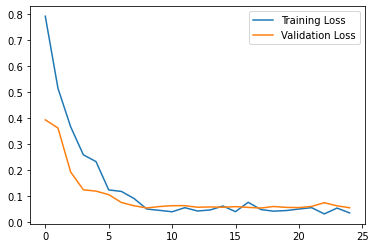

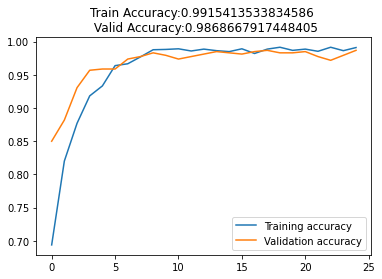

In [39]:
import matplotlib.pyplot as plt


plt.plot(train_loss,label='Training Loss')  
plt.plot(val_loss,label='Validation Loss')  
plt.legend()  
plt.show()  
print()
plt.plot(train_acc,label='Training accuracy')  
plt.plot(val_acc,label='Validation accuracy')  
plt.title('Train Accuracy:{train} \n Valid Accuracy:{valid}'.format(train = max(train_acc),valid= max(val_acc)))
plt.legend()  
plt.show()  

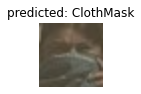

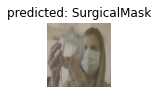

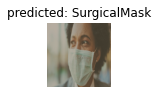

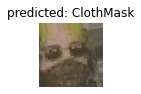

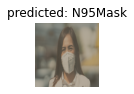

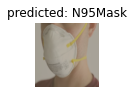

In [29]:
visualize_model(model_ft)

# Performance Analysis on Test data

In [30]:
# accessing the images and thier corresponding labels
# train root path, which unzip from previous cell
DATASET_TEST = '/content/mask-data/Face_Mask_Dataset/Test/'
test_data=[]

for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET_TEST,category)
        for img_file in os.listdir(path):
            
            try:
                img=cv2.imread(os.path.join(path,img_file),1)
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img=cv2.resize(img,(224,224))
                test_data.append([img,label])

            except:
                print("Exception: ",img_file)


print(len(test_data))

439


In [31]:
# make shuffle amoung the data for mixing up
random.shuffle(test_data)
random.shuffle(test_data)
random.shuffle(test_data)
random.shuffle(test_data)

In [32]:
X, y = [], []
for features,label in test_data:
    X.append(features)
    y.append(label)

X_arr = np.array(X).reshape(-1, 224,224,3)
y_arr = np.array(y)
X_arr.shape, y_arr.shape

((439, 224, 224, 3), (439,))

torch.Size([439, 3, 224, 224]) torch.Size([439])
torch.Size([439, 3, 224, 224]) torch.Size([439])
2
              precision    recall  f1-score   support

   ClothMask       0.95      0.96      0.96       101
     N95Mask       0.94      0.70      0.80       136
SurgicalMask       0.73      0.97      0.84       102
 WithoutMask       0.99      1.00      1.00       100

    accuracy                           0.89       439
   macro avg       0.90      0.91      0.90       439
weighted avg       0.91      0.89      0.89       439



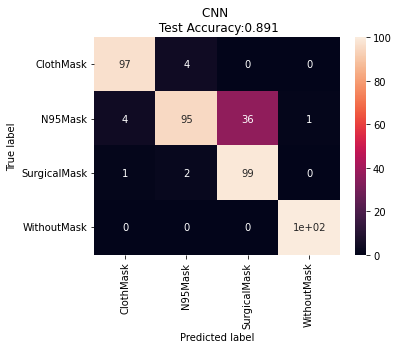

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
import seaborn as sns
import pandas as pd


test_dataset = MASK_DATASET(X_arr, y_arr, transform=transform1)
test_loader = DataLoader(test_dataset, batch_size=len(X_arr), shuffle=True)



dataiter = iter(test_loader)
images, label = dataiter.next()

print(images.shape, label.shape)

images = images.view(images.shape[0],images.shape[1], images.shape[2], images.shape[3])

print(images.shape, label.shape)


output = model_ft(images.to(device)).to(device)
_,pred=torch.max(output,1)
print(pred[0].item())



# Creates a confusion matrix
y_test = label.tolist()
y_pred = pred.tolist()
cm = confusion_matrix(y_test, y_pred) 

print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = CATEGORIES, 
                     columns = CATEGORIES)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('CNN \n Test Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()